<a href="https://colab.research.google.com/github/luca-arts/luca-arts.github.io/blob/main/knowledge/AI/notebooks/Animal_faces_latent_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Animal faces interpolation

an example notebook to try to interpolate between two insects in latent space.

Based on [Noufals blog](https://medium.com/@noufalsamsudin/latent-space-interpolation-of-images-using-keras-and-tensorflow-js-7e35bec01c5a) & [classification code on Kaggle](https://www.kaggle.com/code/vencerlanz09/insect-classification-using-cnn-mobilenetv2)


In [2]:
!nvidia-smi

Thu Aug 25 18:22:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

In [5]:
# System libraries
from pathlib import Path
import os.path


In [6]:
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [7]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## linking GDrive to save models

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
from datetime import date
model_save_name = date.today()
model_path = "/content/gdrive/My Drive/{}".format(model_save_name) 

2022-08-25


## downloading the Kaggle dataset

Make sure you upload your Kaggle API key JSON file here. (via Kaggle, profile, Account)

Via [link](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/)

In [10]:
dataset_name = "andrewmvd/animal-faces"
dataset = "animal-faces"

In [12]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download {dataset_name}
!unzip {dataset}.zip

Streaming output truncated to the last 5000 lines.
  inflating: afhq/train/wild/flickr_wild_001378.jpg  
  inflating: afhq/train/wild/flickr_wild_001379.jpg  
  inflating: afhq/train/wild/flickr_wild_001380.jpg  
  inflating: afhq/train/wild/flickr_wild_001381.jpg  
  inflating: afhq/train/wild/flickr_wild_001382.jpg  
  inflating: afhq/train/wild/flickr_wild_001384.jpg  
  inflating: afhq/train/wild/flickr_wild_001385.jpg  
  inflating: afhq/train/wild/flickr_wild_001386.jpg  
  inflating: afhq/train/wild/flickr_wild_001387.jpg  
  inflating: afhq/train/wild/flickr_wild_001388.jpg  
  inflating: afhq/train/wild/flickr_wild_001389.jpg  
  inflating: afhq/train/wild/flickr_wild_001390.jpg  
  inflating: afhq/train/wild/flickr_wild_001391.jpg  
  inflating: afhq/train/wild/flickr_wild_001392.jpg  
  inflating: afhq/train/wild/flickr_wild_001393.jpg  
  inflating: afhq/train/wild/flickr_wild_001394.jpg  
  inflating: afhq/train/wild/flickr_wild_001395.jpg  
  inflating: afhq/train/wild/fl

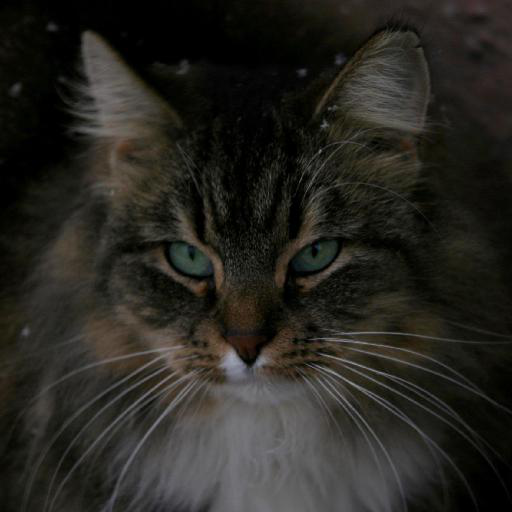

In [13]:
test_img = keras.utils.load_img('/content/afhq/train/cat/flickr_cat_000002.jpg')
test_img

In [14]:
# hyperparameters
BATCH_SIZE = 64
img_height = 512
img_width = 512
img_dir = '/content/afhq/'
resize_factor = 8
SHAPE=(int(img_height/resize_factor),int(img_width/resize_factor))
EPOCHS=64
# Load the data
ds = keras.utils.image_dataset_from_directory(
    '/content/afhq/train',
    # labels="None", 
    label_mode=None,
    batch_size=BATCH_SIZE, 
    image_size=SHAPE
    )
print(type(ds))

Found 14630 files belonging to 1 classes.
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


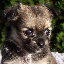

In [15]:
# show the first example of the batch
it = iter(ds)
test_img_batch = next(it)
test_img = test_img_batch[0]
# test_img_label = test_img_batch[1][0]
# print(ds.class_names[test_img_label.numpy()])
test_img = keras.preprocessing.image.array_to_img(test_img)
test_img

In [16]:
for image_batch in ds:
  print(image_batch.shape)
  print(image_batch.shape[1:])

  # print(labels_batch.shape)
  break

(64, 64, 64, 3)
(64, 64, 3)


In [17]:
from keras.layers import Input, Rescaling, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D
# auto-encoder model
input=Input(shape=image_batch.shape[1:])
encoded=Conv2D(32, (3, 3), activation='relu', padding='same')(input)
encoded=MaxPooling2D((2, 2), padding='same')(encoded)
encoded=Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
encoded=MaxPooling2D((2, 2), padding='same')(encoded)
encoded=Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
encoded=Flatten()(encoded)

decoded=Reshape((int(64/resize_factor),int(64/resize_factor),-1))(encoded)#(32, 32, 32))(encoded)
decoded=Conv2D(8, (3, 3), activation='relu', padding='same')(decoded)
decoded=UpSampling2D((2, 2))(decoded)
decoded=Conv2D(16, (3, 3), activation='relu', padding='same')(decoded)
decoded=UpSampling2D((2, 2))(decoded)
decoded=Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded=UpSampling2D((2, 2))(decoded)
decoded=Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)
        
autoencoder=Model(input,decoded)
#TODO: decoder has wrong shape at the end?
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 8)         1160  

In [18]:
encoder = Model(inputs=autoencoder.input, outputs = autoencoder.layers[6].output)
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 8)         1160

In [19]:
encoded_input = Input(shape=(2048,))

deco = autoencoder.layers[-8](encoded_input)
deco = autoencoder.layers[-7](deco)
deco = autoencoder.layers[-6](deco)
deco = autoencoder.layers[-5](deco)
deco = autoencoder.layers[-4](deco)
deco = autoencoder.layers[-3](deco)
deco = autoencoder.layers[-2](deco)
deco = autoencoder.layers[-1](deco)
# create the decoder model
decoder = Model(encoded_input, deco)
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2048)]            0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 32)          0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 8)           2312      
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 up_sampling2d_1 (UpSampling  (None, 32, 32, 16)       0         
 2D)                                                       

In [20]:
#compile the model
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=6)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.Accuracy()])

In [21]:
len(autoencoder.layers),len(encoder.layers),len(decoder.layers)

(15, 7, 9)

Found 14630 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


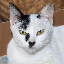

In [23]:
image_generator = ImageDataGenerator(rescale=1.0 / 255)
train_gen = image_generator.flow_from_directory(
    os.path.join(img_dir, "train"), 
    class_mode="input", target_size=SHAPE, batch_size=BATCH_SIZE,
)
val_gen = image_generator.flow_from_directory(
    os.path.join(img_dir, "val"), 
    class_mode="input", target_size=SHAPE, batch_size=BATCH_SIZE,
)
for image, label in train_gen:
  img = keras.preprocessing.image.array_to_img(image[0])
  break
img

In [24]:
hist = autoencoder.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callback])

Epoch 1/64
229/229 [==============================] - 70s 256ms/step - loss: 0.6387 - accuracy: 7.7876e-08 - val_loss: 0.6135 - val_accuracy: 1.0851e-07
Epoch 2/64
229/229 [==============================] - 58s 254ms/step - loss: 0.6087 - accuracy: 1.0569e-07 - val_loss: 0.6039 - val_accuracy: 2.1701e-07
Epoch 3/64
229/229 [==============================] - 58s 255ms/step - loss: 0.6029 - accuracy: 1.0013e-07 - val_loss: 0.5997 - val_accuracy: 1.6276e-07
Epoch 4/64
229/229 [==============================] - 58s 254ms/step - loss: 0.5998 - accuracy: 1.0013e-07 - val_loss: 0.6007 - val_accuracy: 2.1701e-07
Epoch 5/64
229/229 [==============================] - 58s 254ms/step - loss: 0.5974 - accuracy: 1.1681e-07 - val_loss: 0.5954 - val_accuracy: 0.0000e+00
Epoch 6/64
229/229 [==============================] - 58s 254ms/step - loss: 0.5958 - accuracy: 1.3350e-07 - val_loss: 0.5938 - val_accuracy: 1.0851e-07
Epoch 7/64
229/229 [==============================] - 58s 254ms/step - loss: 0.594

In [25]:
autoencoder.save(os.path.join(model_path,"autoencoder"))

# try out basic inference

In [30]:
predict_res = autoencoder.predict(val_gen)

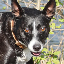

In [35]:
for image in predict_res:
  pred_img = keras.preprocessing.image.array_to_img(image)
  break
# 2. pick an image from val_gen
for image, label in val_gen:
  inf_img = keras.preprocessing.image.array_to_img(image[0])
  break
inf_img

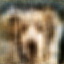

In [36]:
pred_img